In [ ]:
import pandas as pd
import csv
import seaborn as sns
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [ ]:
# Important reference links
# Github data: https://github.com/JeffSackmann/tennis_MatchChartingProject 
# Example match stats for reference: http://tennisabstract.com/charting/20150321-M-Irving_CH-SF-Gilles_Muller-Tim_Smyczek.html 
# Symbol key: http://www.tennisabstract.com/blog/2015/09/23/the-match-charting-project-quick-start-guide/ 
# Harvard reference paper: https://harvardsportsanalysis.org/2021/07/sorting-strokes-classifying-tennis-players-based-on-stats-and-style/ 

In [ ]:
# Load in data
matches = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-w-matches.csv', encoding='windows-1252', engine='python', error_bad_lines=False)
rally = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-w-stats-Rally.csv')
shot_type = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-w-stats-ShotTypes.csv')
shot_dir = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-w-stats-ShotDirection.csv') # Some matches have all 0s for shot direction (but match was still played)
serve_inf = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-w-stats-ServeInfluence.csv')
pts = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-w-points-from-2017.csv', encoding='windows-1252')
stats = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-w-stats-Overview.csv')

<ipython-input-3-e9f4130f30f2>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  matches = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-w-matches.csv', encoding='windows-1252', engine='python', error_bad_lines=False)
Skipping line 1904: unexpected end of data
<ipython-input-3-e9f4130f30f2>:7: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  pts = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_MatchChartingProject/master/charting-w-points-from-2017.csv', encoding='windows-1252')


In [ ]:
# Top tournaments recorded in the dataset
matches.groupby(['Tournament']).size().to_frame().sort_values([0], ascending = False).head(10).reset_index()

,Tournament,0
0,Australian Open,186
1,US Open,149
2,Wimbledon,134
3,Roland Garros,128
4,Indian Wells,93
5,Miami,78
6,Madrid,45
7,Rome,39
8,Cincinnati,37
9,Doha,36


In [ ]:
# Filter out matches that were played before 2017
matches = matches.loc[matches['Date'].astype(str).str[:4].astype(int) >= 2017]
match_ids = matches['match_id']
rally = rally[rally['match_id'].isin(match_ids)]
pts = pts[['match_id', 'Svr', 'Ret', 'Serving', '1st', '2nd', '1stIn', '2ndIn', 'isAce', 'isUnret', 'isRallyWinner', 'isForced', 'isUnforced', 'isDouble', 'PtWinner', 'isSvrWinner', 'rallyCount']]

In [ ]:
# Creates list of players from match data
g1 = list(matches['match_id'].map(lambda id: id.split('-')).str[4]) # Retrieve first player name in match ID
for i in range(len(g1)):
  # Clean up miscellaneous characters in player names
  if g1[i][-1] == '_':
    g1[i] = g1[i][:-1]
  if '\xa0' in g1[i]:
    g1[i] = g1[i][:g1[i].index('\xa0')]
g2 = list(matches['match_id'].map(lambda id: id.split('-')).str[5]) # Retrieve second player name in match ID
for i in range(len(g2)):
  # Clean up miscellaneous characters in player names
  if g2[i][-1] == '_':
    g2[i] = g2[i][:-1]
  if '\xa0' in g2[i]:
    g2[i] = g2[i][:g2[i].index('\xa0')]
players = set(g1).union(set(g2))
players = list(players)

In [ ]:
# Retrieve the number of matches recorded for each player in the player list
num_matches = {players[i]: 0 for i in range(len(players))}
for idx in matches.index:
  p1 = matches['Player 1'][idx].replace(' ', '_')
  p2 = matches['Player 2'][idx].replace(' ', '_')
  if '\xa0' in p1:
    p1 = p1[:p1.index('\xa0')]
  if '\xa0' in p2:
    p2 = p2[:p2.index('\xa0')]
  if p1 in num_matches.keys():
    num_matches[p1] += 1
  if p2 in num_matches.keys():
    num_matches[p2] += 1

Kiki_Bertens 112
Bianca_Andreescu 109
Iga_Swiatek 88
Elina_Svitolina 67
Ashleigh_Barty 49
Naomi_Osaka 47
Garbine_Muguruza 37
123
54
34


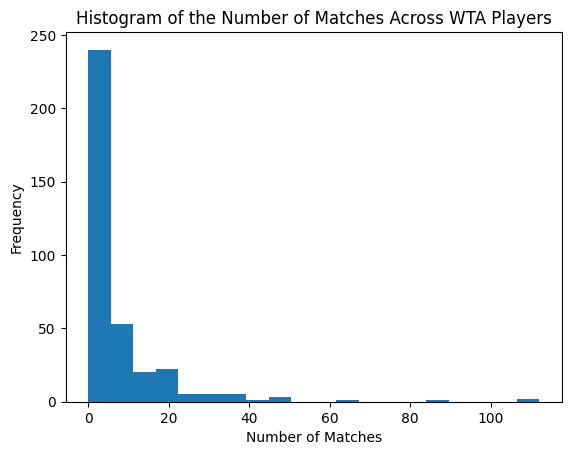

In [ ]:
# Histogram of the number of matches recorded across WTA players
plt.hist(num_matches.values(), 20)
plt.title('Histogram of the Number of Matches Across WTA Players')
plt.xlabel('Number of Matches')
plt.ylabel('Frequency')

# Player with the most amount of matches/data recorded (112 total matches recorded)
print(list(num_matches.keys())[list(num_matches.values()).index(max(num_matches.values()))], max(num_matches.values()))

# Player with the second highest number of matches recorded (109)
print(list(num_matches.keys())[list(num_matches.values()).index(sorted(list(num_matches.values()))[-2])], sorted(list(num_matches.values()))[-2])

# Player with the third highest number of matches recorded (88)
print(list(num_matches.keys())[list(num_matches.values()).index(sorted(list(num_matches.values()))[-3])], sorted(list(num_matches.values()))[-3])

# Player with the fourth highest number of matches recorded (67)
print(list(num_matches.keys())[list(num_matches.values()).index(sorted(list(num_matches.values()))[-4])], sorted(list(num_matches.values()))[-4])

# Player with the fifth highest number of matches recorded (49)
print(list(num_matches.keys())[list(num_matches.values()).index(sorted(list(num_matches.values()))[-5])], sorted(list(num_matches.values()))[-5])

# Player with the sixth highest number of matches recorded (47)
print(list(num_matches.keys())[list(num_matches.values()).index(sorted(list(num_matches.values()))[-7])], sorted(list(num_matches.values()))[-7])

# Player with the ninth highest number of matches recorded (37)
print(list(num_matches.keys())[list(num_matches.values()).index(sorted(list(num_matches.values()))[-9])], sorted(list(num_matches.values()))[-9])

# Out of the 353 players, 123 players have only one match recorded in the dataset
print(list(num_matches.values()).count(1))

# Out of the 353 players, 54 players have only two matches recorded in the dataset
print(list(num_matches.values()).count(2))

# Out of the 353 players, 34 players have only three matches recorded in the dataset
print(list(num_matches.values()).count(3))

Text(0.5, 1.0, 'Histogram of Individuals Charting Matches')

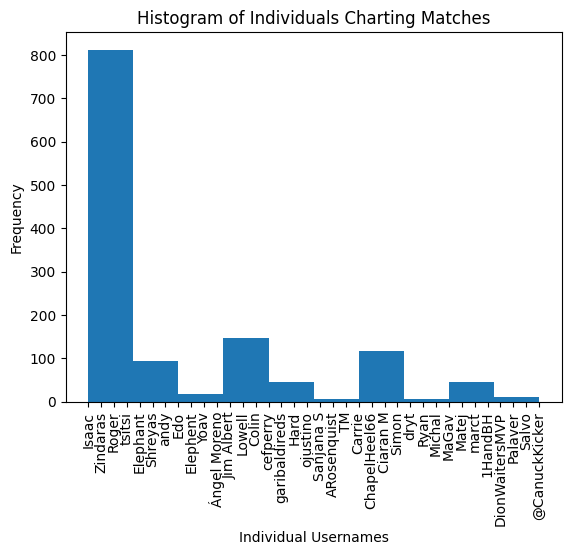

In [ ]:
# Histogram of the number of matches individuals record
plt.hist(matches['Charted by'])
plt.xticks(rotation=90)
plt.xlabel('Individual Usernames')
plt.ylabel('Frequency')
plt.title('Histogram of Individuals Charting Matches')

Text(0.5, 1.0, 'Histogram of Individuals Charting Kiki Bertens Matches')

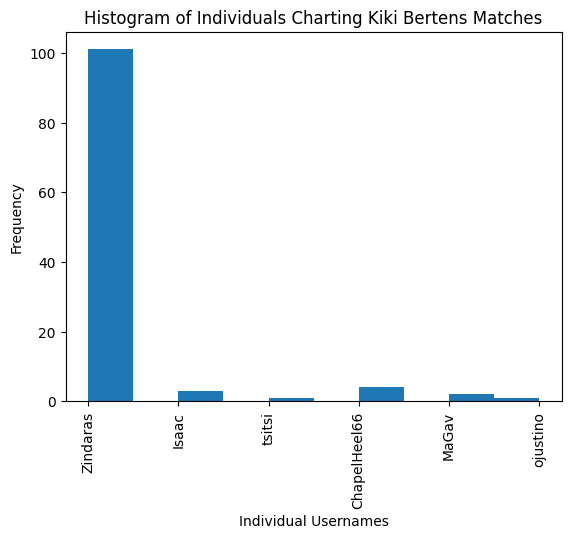

In [ ]:
# Histogram of the individuals charting Kiki Bertens's matches
names = []
for idx in matches.index:
  if matches['Player 1'][idx] == 'Kiki Bertens':
    names.append(matches['Charted by'][idx])
  if matches['Player 2'][idx] == 'Kiki Bertens':
    names.append(matches['Charted by'][idx])
plt.hist(names)
plt.xticks(rotation=90)
plt.xlabel('Individual Usernames')
plt.ylabel('Frequency')
plt.title('Histogram of Individuals Charting Kiki Bertens Matches')
# Heavily skewed towards Zindaras charting Kiki Bertens' matches

Text(0.5, 1.0, 'Histogram of Individuals Charting Bianca Andreescu Matches')

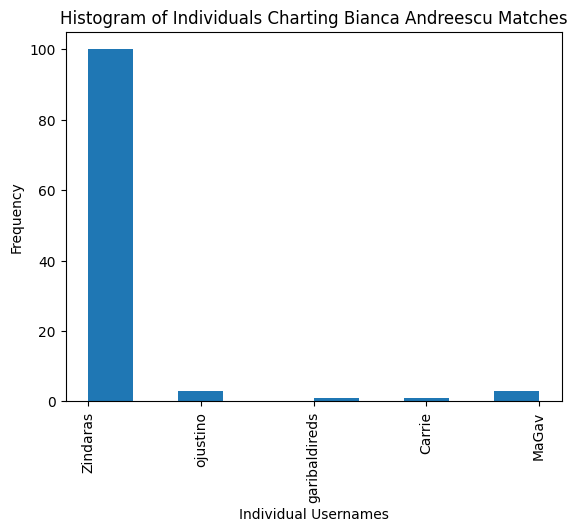

In [ ]:
# Histogram of the individuals charting Bianca Andreescu's matches
names = []
for idx in matches.index:
  if matches['Player 1'][idx] == 'Bianca Andreescu':
    names.append(matches['Charted by'][idx])
  if matches['Player 2'][idx] == 'Bianca Andreescu':
    names.append(matches['Charted by'][idx])
plt.hist(names)
plt.xticks(rotation=90)
plt.xlabel('Individual Usernames')
plt.ylabel('Frequency')
plt.title('Histogram of Individuals Charting Bianca Andreescu Matches')
# Heavily skewed towards Zindaras charting Biana Andreescu's matches

Text(0.5, 1.0, 'Histogram of Individuals Charting Iga Swiatek Matches')

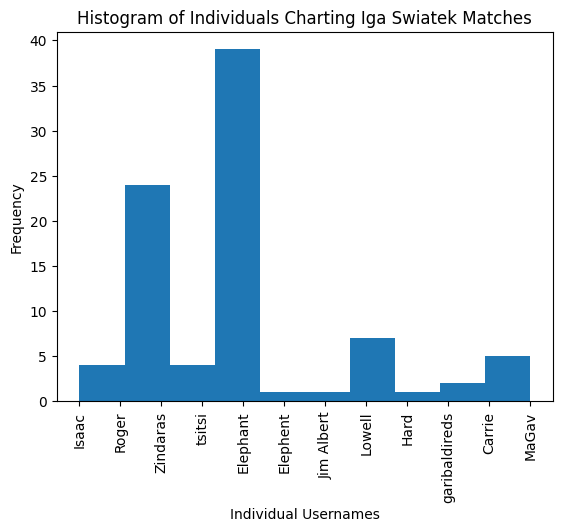

In [ ]:
# Histogram of the individuals charting Iga Swiatek's matches
names = []
for idx in matches.index:
  if matches['Player 1'][idx] == 'Iga Swiatek':
    names.append(matches['Charted by'][idx])
  if matches['Player 2'][idx] == 'Iga Swiatek':
    names.append(matches['Charted by'][idx])
plt.hist(names)
plt.xticks(rotation=90)
plt.xlabel('Individual Usernames')
plt.ylabel('Frequency')
plt.title('Histogram of Individuals Charting Iga Swiatek Matches')
# Heavily skewed towards Elephant and Zindaras charting most of Iga Swiatek's matches

Text(0.5, 1.0, 'Histogram of Individuals Charting Elina Svitolina Matches')

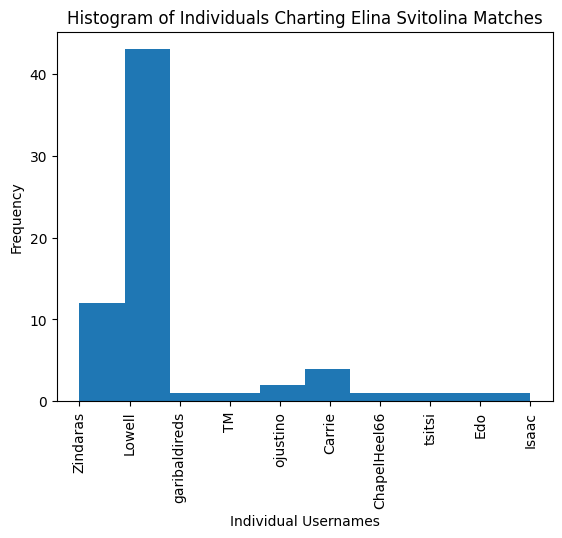

In [ ]:
# Histogram of the individuals charting Elina Svitolina's matches
names = []
for idx in matches.index:
  if matches['Player 1'][idx] == 'Elina Svitolina':
    names.append(matches['Charted by'][idx])
  if matches['Player 2'][idx] == 'Elina Svitolina':
    names.append(matches['Charted by'][idx])
plt.hist(names)
plt.xticks(rotation=90)
plt.xlabel('Individual Usernames')
plt.ylabel('Frequency')
plt.title('Histogram of Individuals Charting Elina Svitolina Matches')
# Heavily skewed towards Lowell charting most of Elina Svitolina's matches

Text(0.5, 1.0, 'Histogram of Individuals Charting Ashleigh Barty Matches')

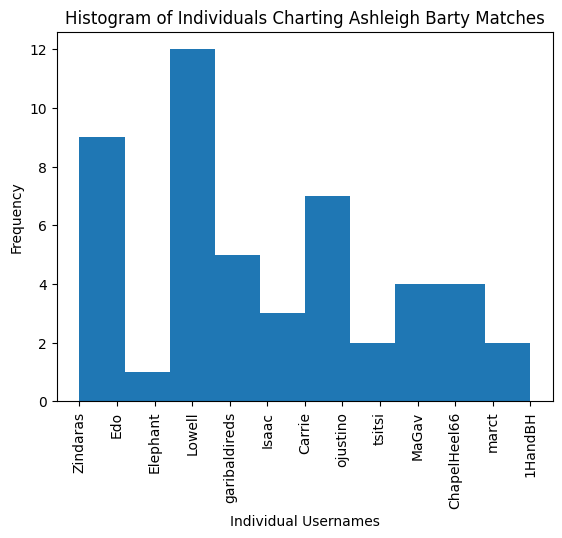

In [ ]:
# Histogram of the individuals charting Ashleigh Barty's matches
names = []
for idx in matches.index:
  if matches['Player 1'][idx] == 'Ashleigh Barty':
    names.append(matches['Charted by'][idx])
  if matches['Player 2'][idx] == 'Ashleigh Barty':
    names.append(matches['Charted by'][idx])
plt.hist(names)
plt.xticks(rotation=90)
plt.xlabel('Individual Usernames')
plt.ylabel('Frequency')
plt.title('Histogram of Individuals Charting Ashleigh Barty Matches')
# A more even distribution of individuals charting Ashleigh Barty's matches

Text(0.5, 1.0, 'Histogram of Isaac Charting WTA Matches')

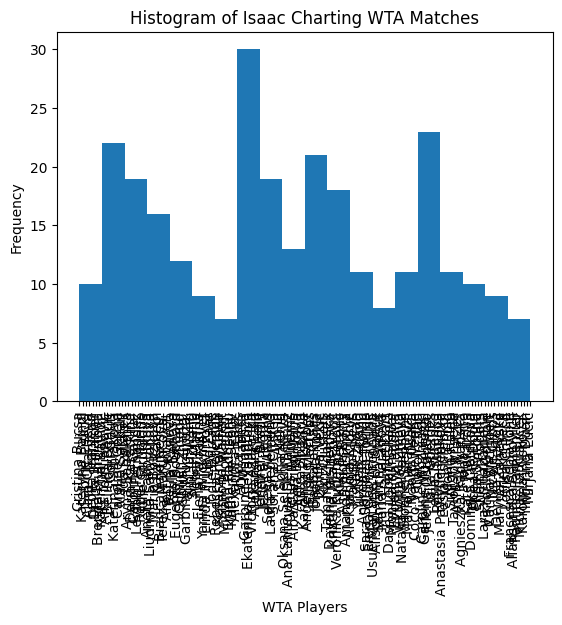

In [ ]:
# Histogram of Isaac charting WTA matches
names = []
for idx in matches.index:
  if matches['Charted by'][idx] == 'Isaac':
    names.append(matches['Player 1'][idx])
    names.append(matches['Player 2'][idx])
plt.hist(names, 20)
plt.xticks(rotation=90)
plt.xlabel('WTA Players')
plt.ylabel('Frequency')
plt.title('Histogram of Isaac Charting WTA Matches')
# A much more even distribution across many WTA player matches

In [ ]:
# Filter out player list to only players who have more than 2 matches recorded in the dataset
new_players = []
for i in range(len(players)):
  if num_matches[players[i]] != 1 and num_matches[players[i]] != 2:
    new_players.append(players[i])
players = new_players
print(len(new_players))

181


In [ ]:
# Get match IDs given player name separated by underscores (e.g. 'Sloane_Stephens')
def get_match_ids(player_name):
  player_match_ids = [id for id in matches['match_id'] if player_name in id]
  return player_match_ids

In [ ]:
# Change the serve influence percentages to numeric values 
serve_inf["won_1+"] = pd.to_numeric(serve_inf["won_1+"].str.replace("%", ""), errors="coerce") / 100
serve_inf["won_2+"] = pd.to_numeric(serve_inf["won_2+"].str.replace("%", ""), errors="coerce") / 100
serve_inf["won_3+"] = pd.to_numeric(serve_inf["won_3+"].str.replace("%", ""), errors="coerce") / 100
serve_inf["won_4+"] = pd.to_numeric(serve_inf["won_4+"].str.replace("%", ""), errors="coerce") / 100
serve_inf["won_5+"] = pd.to_numeric(serve_inf["won_5+"].str.replace("%", ""), errors="coerce") / 100

In [ ]:
# Get the average serve influence stats for a specific player
def get_serve_influence_stats(player_name):
  matches_played = get_match_ids(player_name)
  num_matches = len(matches_played)

  # Find whether the current player was marked as player 1 or 2 for all matches
  player_ids = dict(zip(matches_played, [2 if id.split('-')[-1] == player_name else 1 for id in matches_played]))

  # Shows the percentage of points won by the server for a specific range of rally lengths
  s1_1 = 0
  s1_2 = 0
  s1_3 = 0
  s1_4 = 0
  s1_5 = 0

  s2_1 = 0
  s2_2 = 0
  s2_3 = 0
  s2_4 = 0
  s2_5 = 0

  for j in range(num_matches):
    # Player ID is either 1 or 2
    curr_id = player_ids[matches_played[j]]

    # Isolate statistics for only the current match
    curr_match = serve_inf.loc[serve_inf['match_id'] == matches_played[j]]

    s1 = curr_match.loc[curr_match['row'] == '1 ' + str(curr_id)]
    s2 = curr_match.loc[curr_match['row'] == '2 ' + str(curr_id)]

    if s1['won_1+'].size > 0:
      s1_1 += s1['won_1+'].iloc[0]
    if s1['won_2+'].size > 0:
      s1_2 += s1['won_2+'].iloc[0]
    if s1['won_3+'].size > 0:
      s1_3 += s1['won_3+'].iloc[0]
    if s1['won_4+'].size > 0:
      s1_4 += s1['won_4+'].iloc[0]
    if s1['won_5+'].size > 0:
      s1_5 += s1['won_5+'].iloc[0]

    if s2['won_1+'].size > 0:
      s2_1 += s2['won_1+'].iloc[0]
    if s2['won_2+'].size > 0:
      s2_2 += s2['won_2+'].iloc[0]
    if s2['won_3+'].size > 0:
      s2_3 += s2['won_3+'].iloc[0]
    if s2['won_4+'].size > 0:
      s2_4 += s2['won_4+'].iloc[0]
    if s2['won_5+'].size > 0:
      s2_5 += s2['won_5+'].iloc[0]    

  s1_1 /= num_matches
  s1_2 /= num_matches
  s1_3 /= num_matches
  s1_4 /= num_matches
  s1_5 /= num_matches
  s2_1 /= num_matches
  s2_2 /= num_matches
  s2_3 /= num_matches
  s2_4 /= num_matches
  s2_5 /= num_matches

  return (s1_1, s1_2, s1_3, s1_4, s1_5, s2_1, s2_2, s2_3, s2_4, s2_5)

In [ ]:
# Get the average shot type stats for a specific player
def get_shot_type_stats(player_name):
  matches_played = get_match_ids(player_name)
  num_matches = len(matches_played)

  # Find whether the current player was marked as player 1 or 2 for all matches
  player_ids = dict(zip(matches_played, [2 if id.split('-')[-1] == player_name else 1 for id in matches_played]))

  # Initializes baseline shot breakdowns, separating forehand flat and topspin balls with forehand slices
  fh_gs = 0
  bh_gs = 0
  fhs = 0
  bhs = 0
  net_shots = 0

  for j in range(num_matches):
    # Player ID is either 1 or 2
    curr_id = player_ids[matches_played[j]]

    # Isolate statistics for only the current match
    curr_match = shot_type.loc[shot_type['match_id'] == matches_played[j]]

    total_shots = curr_match.loc[(curr_match['row'] == 'Total') & (curr_match['player'] == curr_id)]
    net = curr_match.loc[(curr_match['row'] == 'Net') & (curr_match['player'] == curr_id)]
    fgs = curr_match.loc[(curr_match['row'] == 'F') & (curr_match['player'] == curr_id)]
    bgs = curr_match.loc[(curr_match['row'] == 'B') & (curr_match['player'] == curr_id)]
    fs = curr_match.loc[(curr_match['row'] == 'R') & (curr_match['player'] == curr_id)]
    bs = curr_match.loc[(curr_match['row'] == 'S') & (curr_match['player'] == curr_id)]

    if (net['shots'].size) > 0:
      net_shots += net['shots'].iloc[0] / total_shots['shots'].iloc[0]
    if (fgs['shots'].size) > 0:
      fh_gs += fgs['shots'].iloc[0] / total_shots['shots'].iloc[0]
    if (bgs['shots'].size) > 0:
      bh_gs += bgs['shots'].iloc[0] / total_shots['shots'].iloc[0]
    if (fs['shots'].size) > 0:
      fhs += fs['shots'].iloc[0] / total_shots['shots'].iloc[0]
    if (bs['shots'].size) > 0:
      bhs += bs['shots'].iloc[0] / total_shots['shots'].iloc[0]

  fh_gs /= num_matches
  bh_gs /= num_matches
  slices = (bhs + fhs) / num_matches
  net_shots /= num_matches

  return(fh_gs, bh_gs, slices, net_shots)


In [ ]:
# Get average rally stats by point length for a specific player
def get_rally_stats(player_name):
    matches_played = get_match_ids(player_name)

    # Find whether the current player was marked as player 1 or 2 for all matches
    player_ids = dict(zip(matches_played, [2 if id.split('-')[-1] == player_name else 1 for id in matches_played]))
    
    short_pt_ratio = 0
    medium_pt_ratio = 0
    long_pt_ratio = 0

    short_pt_w_ratio = 0
    medium_pt_w_ratio = 0
    long_pt_w_ratio = 0

    for j in range(len(matches_played)):
      long_point_won = 0
      long_point_count = 0
      long_count = 0

      # Player ID is either 1 or 2
      curr_id = player_ids[matches_played[j]]

      # Isolate statistics for only the current match
      curr_match = rally.loc[rally['match_id'] == matches_played[j]]

      # Parses the rows into specific rally length
      total_pt = curr_match.loc[curr_match['row'] == 'Total']
      short_pt = curr_match.loc[curr_match['row'] == '1-3']
      medium_pt = curr_match.loc[curr_match['row'] == '4-6']
      long_pt = curr_match.loc[curr_match['row'] == '7-9']
      longest_pt = curr_match.loc[curr_match['row'] == '10']
      
      # Obtains ratio of points of length X played to total points of length X played
      if (short_pt['pts']).size > 0:
        short_pt_ratio += short_pt['pts'].values[0] / total_pt['pts'].values[0]
      if (medium_pt['pts']).size > 0:
        medium_pt_ratio += medium_pt['pts'].values[0] / total_pt['pts'].values[0]

      if (long_pt['pts']).size > 0:
        long_count += long_pt['pts'].values[0] 
      if (longest_pt['pts']).size > 0:
        long_count += longest_pt['pts'].values[0]
      
      if long_count != 0:
        long_pt_ratio += long_count/ total_pt['pts'].values[0]

      # Obtains ratio of points of length X won to total points of length X played
      if (short_pt['pl' + str(curr_id) + '_won']).size > 0:
        short_pt_w_ratio += short_pt['pl' + str(curr_id) + '_won'].values[0] / short_pt['pts'].values[0]
      if (medium_pt['pl' + str(curr_id) + '_won']).size > 0:
        medium_pt_w_ratio += medium_pt['pl' + str(curr_id) + '_won'].values[0] / medium_pt['pts'].values[0]

      if (long_pt['pl' + str(curr_id) + '_won']).size > 0:
        long_point_won += long_pt['pl' + str(curr_id) + '_won'].values[0] 
        long_point_count += long_pt['pts'].values[0]
      if (longest_pt['pl' + str(curr_id) + '_won']).size > 0:
        long_point_won += longest_pt['pl' + str(curr_id) + '_won'].values[0]
        long_point_count += longest_pt['pts'].values[0]
      
      if long_point_count != 0:
        long_pt_w_ratio += long_point_won/ long_point_count

    short_pt_w_ratio /= len(matches_played)
    medium_pt_w_ratio /= len(matches_played)
    long_pt_w_ratio /= len(matches_played)

    short_pt_ratio /= len(matches_played)
    medium_pt_ratio /= len(matches_played)
    long_pt_ratio /= len(matches_played)


    return(short_pt_w_ratio, medium_pt_w_ratio, long_pt_w_ratio, short_pt_ratio, medium_pt_ratio, long_pt_ratio)  

print(get_rally_stats('Sloane_Stephens'))

(0.5125190350258344, 0.5046340406344703, 0.534654416542038, 0.5350896467954218, 0.24887266268328864, 0.21603769052128932)


In [ ]:
# Create dataframe of average match stats for each WTA player
player_data = pd.DataFrame(columns=['Player Name', 'Serve Win Pct', 'Return Win Pct', 'Winners', 'Unforced Errors', 'Short Point W Pct', 'Medium Point W Pct', 'Long Point W Pct', 'Pct of FH GS', 
                                    'Pct of BH GS', 'Pct of Slices', 'Pct of Net Shots', '1st Serve Won 1+', '1st Serve Won 2+', '1st Serve Won 3+', '1st Serve Won 4+',
                                    '1st Serve Won 5+', '2nd Serve Won 1+', '2nd Serve Won 2+', '2nd Serve Won 3+', '2nd Serve Won 4+', '2nd Serve Won 5+'])

for i in range(len(players)):
  match_ids = get_match_ids(players[i])

  # Retrieve player ID (either 1 or 2) from match ID
  player_ids = dict(zip(match_ids, [2 if id.split('-')[-1] == players[i] else 1 for id in match_ids]))
  player_matches = stats.loc[(stats['match_id'].isin(match_ids))]
  match_count = 0
  serve_win_pct = 0
  return_win_pct = 0
  winners = 0
  unforced = 0

  # Get general match statistics
  for ind in player_matches.index:
    if player_matches.loc[ind, 'player'] == player_ids[player_matches.loc[ind, 'match_id']] and player_matches.loc[ind, 'set'] == 'Total':
      serve_win_pct += (player_matches.loc[ind, 'first_won'] + player_matches.loc[ind, 'second_won']) / player_matches.loc[ind, 'serve_pts']
      return_win_pct += player_matches.loc[ind, 'return_pts_won'] / player_matches.loc[ind, 'return_pts']
      winners += player_matches.loc[ind, 'winners']
      unforced += player_matches.loc[ind, 'unforced']
      match_count += 1

  # Get rally stats by shot length
  short_pt_w_ratio,  medium_pt_w_ratio, long_pt_w_ratio, short_pt_ratio,  medium_pt_ratio, long_pt_ratio = get_rally_stats(players[i])
  
  # Get shot types stats
  fh_gs, bh_gs, slices, net_shots = get_shot_type_stats(players[i])

  # Get serve influence stats
  s1_1, s1_2, s1_3, s1_4, s1_5, s2_1, s2_2, s2_3, s2_4, s2_5 = get_serve_influence_stats(players[i])

  # Add averaged match stats to existing dataframe
  if num_matches != 0:

    row = pd.DataFrame({'Player Name': players[i], 'Serve Win Pct': serve_win_pct / match_count, 'Return Win Pct': return_win_pct / match_count,
                        'Winners': winners / match_count, 'Unforced Errors': unforced / match_count, 'Short Point W Pct': short_pt_w_ratio,
                       'Medium Point W Pct': medium_pt_w_ratio, 'Long Point W Pct': long_pt_w_ratio, 'Short Point Pct': short_pt_ratio,
                       'Medium Point Pct': medium_pt_ratio, 'Long Point Pct': long_pt_ratio, 'Pct of FH GS': fh_gs, 'Pct of BH GS': bh_gs,
                        'Pct of Slices': slices, 'Pct of Net Shots': net_shots,  '1st Serve Won 1+': s1_1, '1st Serve Won 2+': s1_2, 
                        '1st Serve Won 3+': s1_3, '1st Serve Won 4+': s1_4, '1st Serve Won 5+': s1_5, '2nd Serve Won 1+': s2_1, '2nd Serve Won 2+': s2_2,
                        '2nd Serve Won 3+': s2_3, '2nd Serve Won 4+': s2_4, '2nd Serve Won 5+': s2_5 }, index=[i])
    
    player_data = pd.concat([player_data, row], axis=0)

player_data = player_data.reset_index(drop=True)
player_data

,Player Name,Serve Win Pct,Return Win Pct,Winners,Unforced Errors,Short Point W Pct,Medium Point W Pct,Long Point W Pct,Pct of FH GS,Pct of BH GS,...,1st Serve Won 4+,1st Serve Won 5+,2nd Serve Won 1+,2nd Serve Won 2+,2nd Serve Won 3+,2nd Serve Won 4+,2nd Serve Won 5+,Short Point Pct,Medium Point Pct,Long Point Pct
0,Ajla_Tomljanovic,0.550572,0.394844,17.700000,26.600000,0.411546,0.461713,0.448266,0.410041,0.358112,...,0.363727,0.474909,0.479636,0.379727,0.459182,0.351000,0.450545,0.534381,0.197698,0.177012
1,Shuai_Zhang,0.541034,0.426860,21.444444,28.444444,0.409787,0.483908,0.464500,0.463168,0.357964,...,0.422000,0.547600,0.571700,0.418900,0.486900,0.379200,0.485200,0.498750,0.224637,0.176612
2,Camila_Giorgi,0.597825,0.423269,25.266667,39.666667,0.473621,0.579639,0.552301,0.484842,0.455928,...,0.504067,0.625933,0.612000,0.462933,0.615600,0.482600,0.606467,0.612886,0.228210,0.158904
3,Coco_Vandeweghe,0.617980,0.377353,22.666667,28.000000,0.487188,0.522705,0.397037,0.456042,0.419452,...,0.508500,0.685333,0.626833,0.526667,0.641167,0.454167,0.633167,0.613036,0.248450,0.138514
4,Simona_Waltert,0.611170,0.518329,35.500000,35.000000,0.375709,0.388514,0.362381,0.297555,0.276051,...,0.344000,0.467000,0.325667,0.287000,0.359667,0.272000,0.464667,0.365480,0.177938,0.123248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,Kaja_Juvan,0.568358,0.413855,21.642857,34.500000,0.494990,0.504928,0.456169,0.422559,0.367451,...,0.444071,0.560429,0.633929,0.535643,0.627500,0.470071,0.593143,0.538013,0.248022,0.213965
177,Elena_Rybakina,0.613986,0.420066,27.000000,31.884615,0.507207,0.522740,0.543031,0.501168,0.391018,...,0.455885,0.588654,0.654038,0.517769,0.622500,0.443423,0.599462,0.599371,0.245233,0.155396
178,Johanna_Konta,0.637581,0.426957,26.166667,29.083333,0.515395,0.563928,0.544748,0.456849,0.407124,...,0.405917,0.609417,0.564583,0.464750,0.595917,0.464750,0.594750,0.597515,0.254253,0.148232
179,Liudmila_Samsonova,0.659802,0.434676,26.500000,28.857143,0.438270,0.492935,0.418481,0.428175,0.347624,...,0.345471,0.490294,0.499588,0.362235,0.500706,0.334118,0.477647,0.552657,0.181421,0.089451


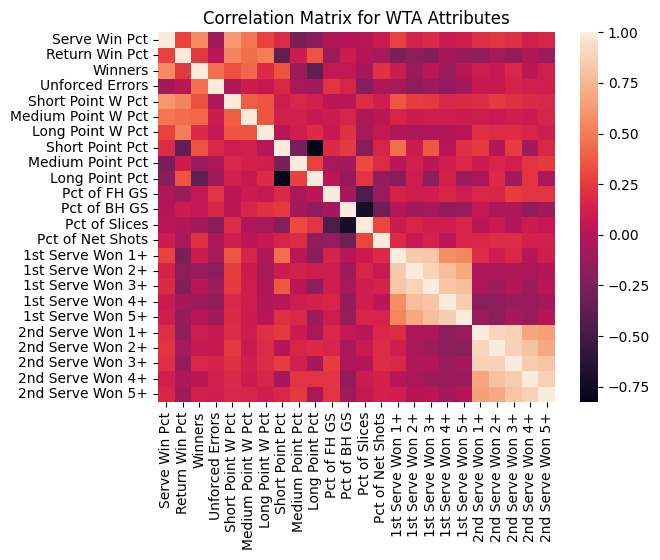

In [ ]:
# Displays a correlation matrix of the WTA player attributes
player_nums = player_data[['Serve Win Pct', 'Return Win Pct', 'Winners', 'Unforced Errors', 'Short Point W Pct', 'Medium Point W Pct', 'Long Point W Pct', 
                           'Short Point Pct', 'Medium Point Pct', 'Long Point Pct', 'Pct of FH GS', 
              'Pct of BH GS', 'Pct of Slices', 'Pct of Net Shots', '1st Serve Won 1+', '1st Serve Won 2+', '1st Serve Won 3+', '1st Serve Won 4+',
              '1st Serve Won 5+', '2nd Serve Won 1+', '2nd Serve Won 2+', '2nd Serve Won 3+', '2nd Serve Won 4+', '2nd Serve Won 5+']]
corr_matrix = player_nums.corr()
sns.heatmap(corr_matrix, annot=False)
plt.title('Correlation Matrix for WTA Attributes')
plt.show()

Text(0.5, 1.0, 'Average Rally Length Percentage Across All WTA Players')

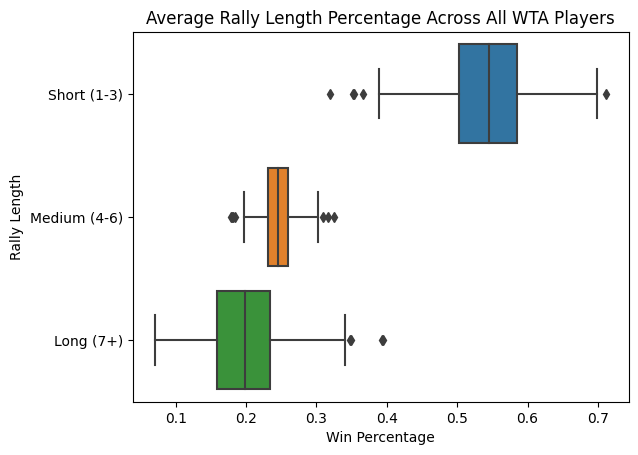

In [ ]:
# Boxplot of average rally length percentage across all WTA players
ax = sns.boxplot(data=pd.melt(player_data[['Short Point Pct', 'Medium Point Pct', 'Long Point Pct']]), x='value', y='variable')
plt.xlabel('Win Percentage')
plt.ylabel('Rally Length')
ax.set_yticklabels(['Short (1-3)', 'Medium (4-6)', 'Long (7+)'])
plt.title('Average Rally Length Percentage Across All WTA Players')

Text(0.5, 1.0, 'Average Number of Winners and Unforced Errors Across All WTA Players')

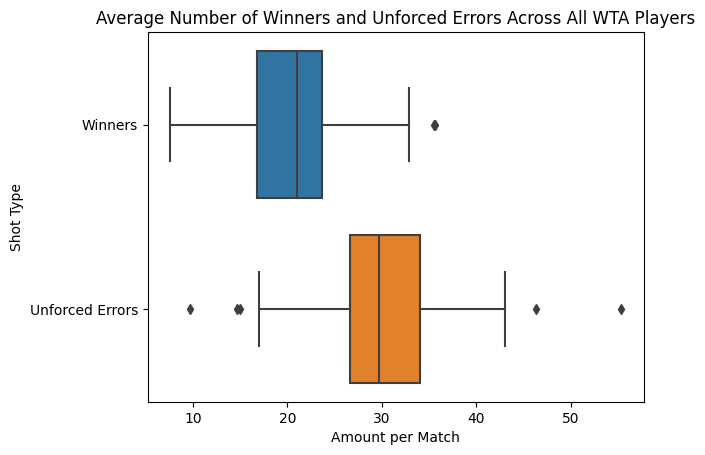

In [ ]:
# Boxplot of average winners and unforced errors across all WTA players
ax = sns.boxplot(data=pd.melt(player_data[['Winners', 'Unforced Errors']]), x='value', y='variable')
plt.xlabel('Amount per Match')
plt.ylabel('Shot Type')
plt.title('Average Number of Winners and Unforced Errors Across All WTA Players')

Text(0.5, 1.0, 'Average Shot Type Percentages Across All WTA Players')

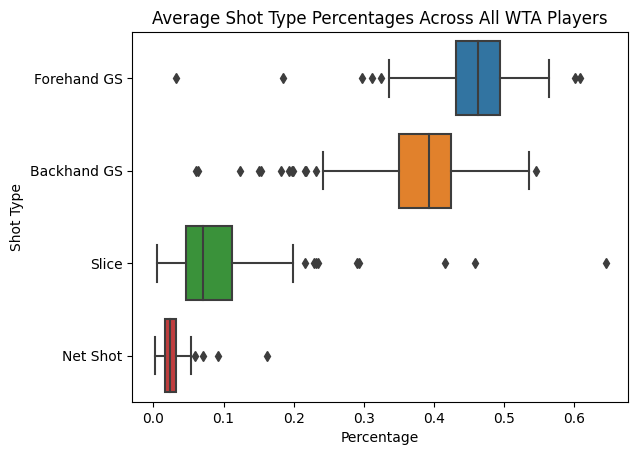

In [ ]:
# Boxplot of average shot types across all WTA players
ax = sns.boxplot(data=pd.melt(player_data[['Pct of FH GS', 'Pct of BH GS', 'Pct of Slices', 'Pct of Net Shots']]), x='value', y='variable')
plt.xlabel('Percentage')
plt.ylabel('Shot Type')
ax.set_yticklabels(['Forehand GS', 'Backhand GS', 'Slice', 'Net Shot'])
plt.title('Average Shot Type Percentages Across All WTA Players')

Text(0.5, 1.0, 'Average Serve and Return Win Percentage Across All WTA Players')

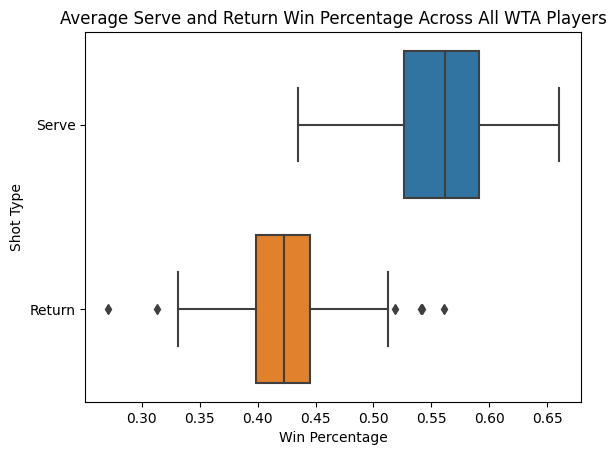

In [ ]:
# Boxplot of average serve and return win percentage across all WTA players
ax = sns.boxplot(data=pd.melt(player_data[['Serve Win Pct', 'Return Win Pct']]), x='value', y='variable')
plt.xlabel('Win Percentage')
plt.ylabel('Shot Type')
ax.set_yticklabels(['Serve', 'Return'])
plt.title('Average Serve and Return Win Percentage Across All WTA Players')

Text(0.5, 1.0, 'Average First Serve Influence Across All WTA Players')

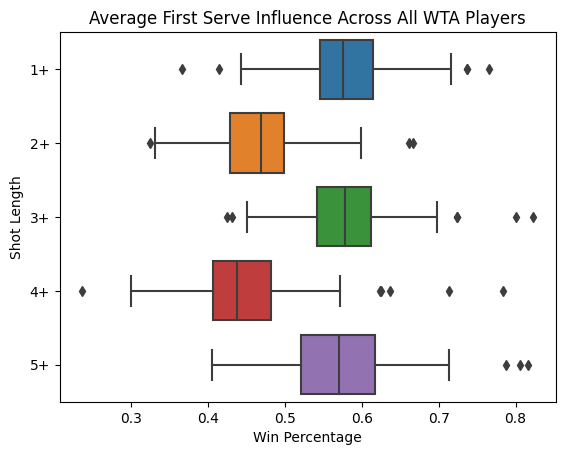

In [ ]:
# Boxplot of average first serve influence across all WTA players
ax = sns.boxplot(data=pd.melt(player_data[['1st Serve Won 1+', '1st Serve Won 2+', '1st Serve Won 3+', '1st Serve Won 4+', '1st Serve Won 5+']]), x='value', y='variable')
plt.xlabel('Win Percentage')
plt.ylabel('Shot Length')
ax.set_yticklabels(['1+', '2+', '3+', '4+', '5+'])
plt.title('Average First Serve Influence Across All WTA Players')

Text(0.5, 1.0, 'Number of Right vs. Left Handed WTA Players')

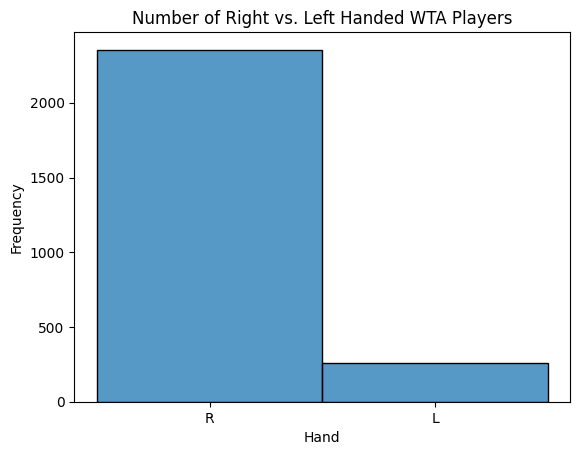

In [ ]:
# Bar graph of ratio of right and left handed WTA players in the dataset
sns.histplot(pd.concat([matches['Pl 1 hand'], matches['Pl 2 hand']]))
plt.xlabel('Hand')
plt.ylabel('Frequency')
plt.title('Number of Right vs. Left Handed WTA Players')

In [ ]:
# Replace NaN values with respective means of the columns
player_data['1st Serve Won 1+'].fillna(value=player_data['1st Serve Won 1+'].mean(), inplace=True)
player_data['1st Serve Won 2+'].fillna(value=player_data['1st Serve Won 2+'].mean(), inplace=True)
player_data['1st Serve Won 3+'].fillna(value=player_data['1st Serve Won 3+'].mean(), inplace=True)
player_data['1st Serve Won 4+'].fillna(value=player_data['1st Serve Won 4+'].mean(), inplace=True)
player_data['1st Serve Won 5+'].fillna(value=player_data['1st Serve Won 5+'].mean(), inplace=True)
player_data['2nd Serve Won 1+'].fillna(value=player_data['2nd Serve Won 1+'].mean(), inplace=True)
player_data['2nd Serve Won 2+'].fillna(value=player_data['2nd Serve Won 2+'].mean(), inplace=True)
player_data['2nd Serve Won 3+'].fillna(value=player_data['2nd Serve Won 3+'].mean(), inplace=True)
player_data['2nd Serve Won 4+'].fillna(value=player_data['2nd Serve Won 4+'].mean(), inplace=True)
player_data['2nd Serve Won 5+'].fillna(value=player_data['2nd Serve Won 5+'].mean(), inplace=True)

In [ ]:
player_data['Winners:Unforced'] = player_data['Winners'] / player_data['Unforced Errors']

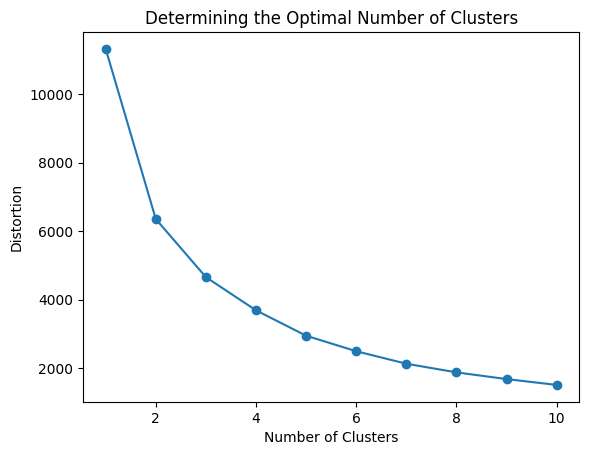

In [ ]:
# Determine the optimal number of clusters using the Elbow Method
# Calculate distortion for a range of number of cluster

data = player_data[['Serve Win Pct', 'Return Win Pct', 'Winners', 'Unforced Errors', 'Short Point Pct', 'Medium Point Pct', 'Long Point Pct',
                    'Pct of FH GS', 'Pct of Slices', 'Pct of Net Shots', '1st Serve Won 1+', '1st Serve Won 2+', '1st Serve Won 3+']]
                    
# ['Serve Win Pct', 'Return Win Pct', 'Winners', 'Unforced Errors', 'Short Point W Pct', 'Medium Point W Pct', 
#                    'Long Point W Pct', 'Pct of FH GS', 'Pct of BH GS', 'Pct of Slices', 'Pct of Net Shots', '1st Serve Won 1+', 
#                    '1st Serve Won 2+', '1st Serve Won 3+', '1st Serve Won 4+', '1st Serve Won 5+']
# '2nd Serve Won 1+', '2nd Serve Won 2+', '2nd Serve Won 3+', '2nd Serve Won 4+', '2nd Serve Won 5+']]

distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)
    km.fit(data)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Determining the Optimal Number of Clusters')
plt.show()

In [ ]:
# Fitting the WTA data with KMeans clustering
num_clusters = 3
km = KMeans(n_clusters=num_clusters, n_init=10, tol=1e-04) # Optimize paramters

km.fit(data)

KMeans(n_clusters=3, n_init=10)

In [ ]:
# Create list of players associated with each cluster/playing style determined by KMeans
playing_styles = {0: [], 1: [], 2:[]}
for ind in player_data.index:
  playing_styles[km.labels_[ind]].append(player_data.loc[ind, 'Player Name'])

player_data['Playing Style'] = np.nan
for idx in player_data.index:
  for style in playing_styles.keys():
    if player_data['Player Name'][idx] in playing_styles[style]:
      player_data['Playing Style'][idx] = int(style)
      break

example_df = pd.DataFrame()
example_players = ['Naomi_Osaka', 'Ons_Jabeur', 'Serena_Williams', 'Ashleigh_Barty', 'Iga_Swiatek', 'Simona_Halep', 'Jelena_Ostapenko', 'Jessica_Pegula', 'Garbine_Muguruza',
                   'Caroline_Wozniacki', 'Madison_Keys', 'Petra_Kvitova', 'Angelique_Kerber' ,'Sloane_Stephens', 'Emma_Radacanu', 'Veronika_Kudermetova']
for player in example_players:
  example_df = pd.concat([example_df, player_data[player_data['Player Name'] == player]])

print(num_matches['Petra_Kvitova'])
print(num_matches['Serena_Williams'])
print(num_matches['Jelena_Ostapenko'])
print(num_matches['Jessica_Pegula'])
print(num_matches['Veronika_Kudermetova'])

example_df[['Player Name', 'Serve Win Pct', 'Return Win Pct', 'Winners', 'Unforced Errors', 'Short Point Pct', 'Medium Point Pct', 'Long Point Pct', 'Pct of FH GS', 'Pct of Slices', 
           'Pct of Net Shots', '1st Serve Won 1+', '1st Serve Won 2+', '1st Serve Won 3+', 'Playing Style']]

<ipython-input-34-c05bea2672b7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['Playing Style'][idx] = int(style)


35
32
29
19
19


,Player Name,Serve Win Pct,Return Win Pct,Winners,Unforced Errors,Short Point Pct,Medium Point Pct,Long Point Pct,Pct of FH GS,Pct of Slices,Pct of Net Shots,1st Serve Won 1+,1st Serve Won 2+,1st Serve Won 3+,Playing Style
98,Naomi_Osaka,0.600869,0.412064,25.021277,29.574468,0.610034,0.239322,0.150644,0.434864,0.025552,0.019502,0.651255,0.485234,0.585809,1.0
13,Ons_Jabeur,0.568004,0.422653,25.259259,34.629630,0.602110,0.256318,0.141571,0.421137,0.143604,0.028785,0.567926,0.443259,0.593296,2.0
47,Serena_Williams,0.635144,0.457668,25.531250,25.937500,0.642008,0.219572,0.138420,0.441636,0.031103,0.034410,0.668000,0.503094,0.656375,1.0
31,Ashleigh_Barty,0.652181,0.450395,26.306122,29.734694,0.553373,0.239786,0.206841,0.456243,0.290258,0.026429,0.696673,0.568408,0.683939,1.0
74,Iga_Swiatek,0.634839,0.512106,22.068966,25.781609,0.554293,0.254702,0.179642,0.463270,0.041094,0.019294,0.634443,0.517148,0.639818,1.0
103,Simona_Halep,0.562708,0.464238,22.888889,31.444444,0.460849,0.260397,0.278754,0.507043,0.023511,0.019722,0.512000,0.416889,0.501889,1.0
27,Jelena_Ostapenko,0.551700,0.436032,28.222222,35.037037,0.600174,0.223245,0.107615,0.424311,0.043144,0.021289,0.522310,0.369000,0.516414,2.0
155,Jessica_Pegula,0.549846,0.420966,18.263158,27.421053,0.549068,0.251859,0.199073,0.433718,0.101016,0.027753,0.590526,0.468947,0.559842,0.0
114,Garbine_Muguruza,0.600018,0.425868,18.235294,26.676471,0.471834,0.209099,0.190862,0.394190,0.025981,0.028349,0.501974,0.413513,0.496308,0.0
66,Caroline_Wozniacki,0.569026,0.451821,15.545455,19.681818,0.488895,0.252280,0.258826,0.474037,0.068996,0.022894,0.601727,0.470636,0.553864,0.0


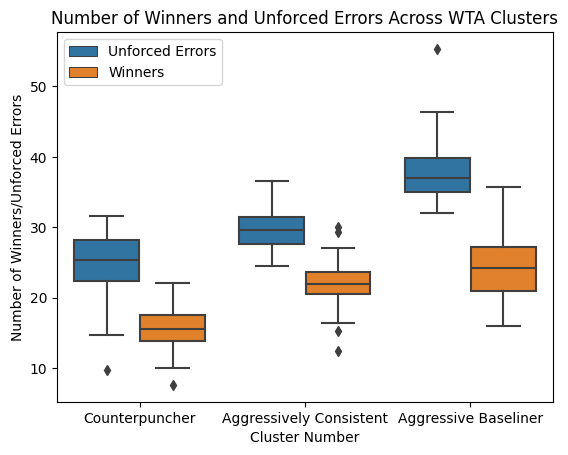

In [ ]:
# Boxplot of winners and unforced errors between the WTA clusters
df_uw = pd.melt(player_data[['Unforced Errors', 'Winners']])
df = pd.concat([df_uw, pd.DataFrame(np.append(km.labels_, km.labels_), columns=['group'])], axis=1)
ax = sns.boxplot(data=df, x='group', y='value', hue='variable')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Winners/Unforced Errors')
plt.title('Number of Winners and Unforced Errors Across WTA Clusters')
ax.set_xticklabels(['Counterpuncher', 'Aggressively Consistent', 'Aggressive Baseliner'])
# plt.axhline(sum(data['Unforced Errors']) / len(data['Unforced Errors']), color='blue', label='Avg Unforced Errors')
# plt.axhline(sum(data['Winners']) / len(data['Winners']), color='orange', label='Avg Winners')
ax.legend()

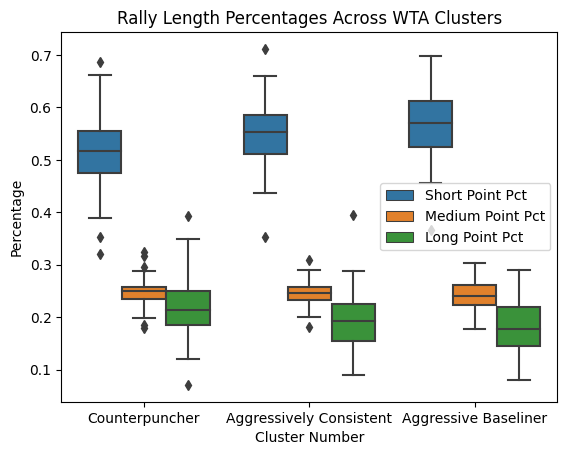

In [ ]:
# Boxplot of win percentage across different rally lengths between the WTA clusters
df_pt = pd.melt(data[['Short Point Pct', 'Medium Point Pct', 'Long Point Pct']])
df = pd.concat([df_pt, pd.DataFrame(np.append(np.append(km.labels_, km.labels_), km.labels_), columns=['group'])], axis=1)
ax = sns.boxplot(data=df, x='group', y='value', hue='variable')
plt.xlabel('Cluster Number')
plt.ylabel('Percentage')
plt.title('Rally Length Percentages Across WTA Clusters')
ax.set_xticklabels(['Counterpuncher', 'Aggressively Consistent', 'Aggressive Baseliner'])
ax.legend()

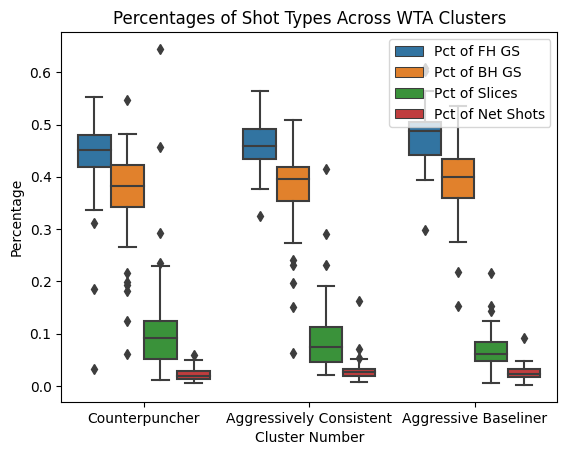

In [ ]:
# Boxplot of win percentage across different rally lengths between the WTA clusters
df_pt = pd.melt(player_data[['Pct of FH GS', 'Pct of BH GS', 'Pct of Slices', 'Pct of Net Shots']])
df = pd.concat([df_pt, pd.DataFrame(np.append(np.append(np.append(km.labels_, km.labels_), km.labels_), km.labels_), columns=['group'])], axis=1)
ax = sns.boxplot(data=df, x='group', y='value', hue='variable')
plt.xlabel('Cluster Number')
plt.ylabel('Percentage')
plt.title('Percentages of Shot Types Across WTA Clusters')
ax.set_xticklabels(['Counterpuncher', 'Aggressively Consistent', 'Aggressive Baseliner'])
ax.legend(loc=1)

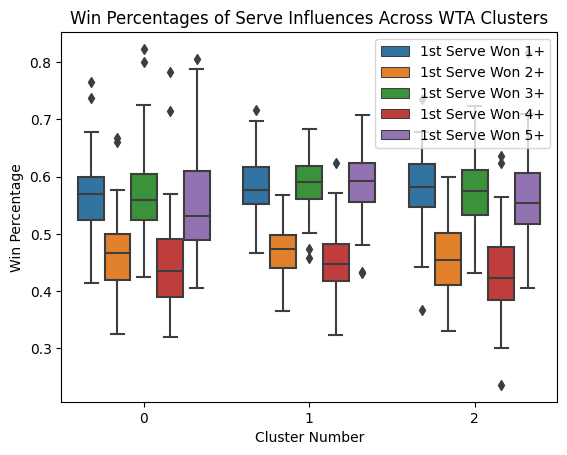

In [ ]:
# Boxplot of win percentage of shots after serve between the WTA clusters
df_pt = pd.melt(player_data[['1st Serve Won 1+', '1st Serve Won 2+', '1st Serve Won 3+', '1st Serve Won 4+', '1st Serve Won 5+']])
df = pd.concat([df_pt, pd.DataFrame(np.append(np.append(np.append(np.append(km.labels_, km.labels_), km.labels_), km.labels_), km.labels_), 
                                    columns=['group'])], axis=1)
ax = sns.boxplot(data=df, x='group', y='value', hue='variable')
plt.xlabel('Cluster Number')
plt.ylabel('Win Percentage')
plt.title('Win Percentages of Serve Influences Across WTA Clusters')
ax.legend(loc=1)

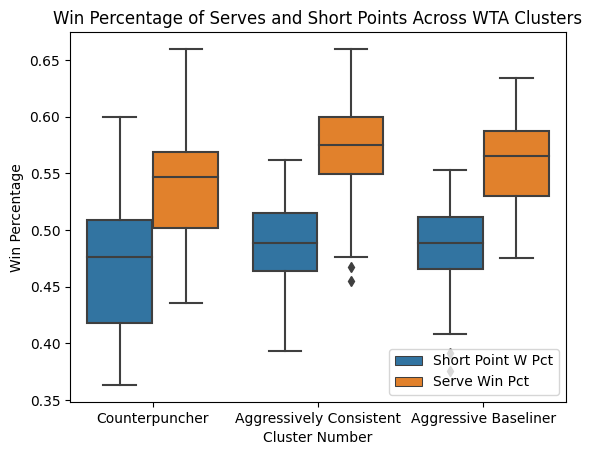

In [ ]:
# Boxplot of win percentages of serves and short points between the WTA clusters
df_uw = pd.melt(player_data[['Short Point W Pct', 'Serve Win Pct']])
df = pd.concat([df_uw, pd.DataFrame(np.append(km.labels_, km.labels_), columns=['group'])], axis=1)
ax = sns.boxplot(data=df, x='group', y='value', hue='variable')
plt.xlabel('Cluster Number')
plt.ylabel('Win Percentage')
plt.title('Win Percentage of Serves and Short Points Across WTA Clusters')
ax.set_xticklabels(['Counterpuncher', 'Aggressively Consistent', 'Aggressive Baseliner'])
ax.legend()

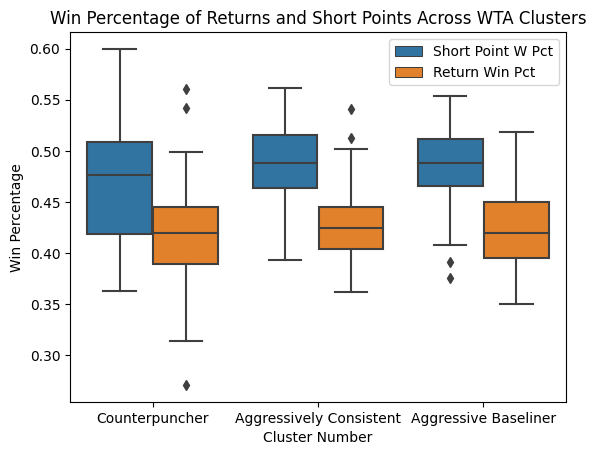

In [ ]:
# Boxplot of win percentages of serves and short points between the WTA clusters
df_uw = pd.melt(player_data[['Short Point W Pct', 'Return Win Pct']])
df = pd.concat([df_uw, pd.DataFrame(np.append(km.labels_, km.labels_), columns=['group'])], axis=1)
ax = sns.boxplot(data=df, x='group', y='value', hue='variable')
plt.xlabel('Cluster Number')
plt.ylabel('Win Percentage')
plt.title('Win Percentage of Returns and Short Points Across WTA Clusters')
ax.set_xticklabels(['Counterpuncher', 'Aggressively Consistent', 'Aggressive Baseliner'])
ax.legend()

In [ ]:
# Obtain W/L match information from 2017
matches_2022 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2022.csv')
matches_2021 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2021.csv')
matches_2020 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2020.csv')
matches_2019 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2019.csv')
matches_2018 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2018.csv')
matches_2017 = pd.read_csv('https://raw.githubusercontent.com/JeffSackmann/tennis_wta/master/wta_matches_2017.csv')

In [ ]:
# Filter matches to just tournament name and winner/loser names
matches_2022 = matches_2022[['tourney_date', 'tourney_name', 'winner_name', 'loser_name']]
matches_2021 = matches_2021[['tourney_date', 'tourney_name', 'winner_name', 'loser_name']]
matches_2020 = matches_2020[['tourney_date', 'tourney_name', 'winner_name', 'loser_name']]
matches_2019 = matches_2019[['tourney_date', 'tourney_name', 'winner_name', 'loser_name']]
matches_2018 = matches_2018[['tourney_date', 'tourney_name', 'winner_name', 'loser_name']]
matches_2017 = matches_2017[['tourney_date', 'tourney_name', 'winner_name', 'loser_name']]

tables = [matches_2022, matches_2021, matches_2020, matches_2019, matches_2018, matches_2017]

In [ ]:
# Fill in winner names for WTA matches
for id in matches['match_id']:
  lid = id.split('-')
  date = lid[0][:4]
  tourney_name = lid[2].replace('_', ' ')
  p1 = lid[4].replace('_', ' ')
  p2 = lid[5].replace('_', ' ')
  for df in tables:
    df['tourney_name'] = df['tourney_name'].apply(str.lower)
    row = df[df['tourney_name'].astype(str).str[-1] == '1']
    for name in row['tourney_name']:
      name = name[:-2]
    row = df[(df['tourney_name'] == tourney_name.lower()) & (df['tourney_date'].astype(str).str[:4] == date)]
    for name in row['winner_name']:
      if name == p1:
        matches.loc[matches['match_id'] == id, 'winner_name'] = p1
        break
      if name == p2:
        matches.loc[matches['match_id'] == id, 'winner_name'] = p2
        break

In [ ]:
# Import the rest of the match winners
matches = pd.read_csv('match_winners.csv')

In [ ]:
# Fill out results dictionary with match IDs
results = {'1 v. 2':[], '1 v. 3':[], '2 v. 1':[], '2 v. 3':[], '3 v. 1':[], '3 v. 2':[]}
for idx in matches.index:
  for style in playing_styles.keys():
    p1 = matches['Player 1'][idx].replace(' ', '_')
    p2 = matches['Player 2'][idx].replace(' ', '_')
    if p1 in playing_styles[style]:
      p1_style = style + 1
    if p2 in playing_styles[style]:
      p2_style = style + 1
  match1 = str(p1_style) + ' v. ' + str(p2_style)
  match2 = str(p2_style) + ' v. ' + str(p1_style)
  if matches['Player 1'][idx] == matches['winner_name'][idx] and match1 in results.keys():
    results[match1].append(matches['match_id'][idx])
  if matches['Player 2'][idx] == matches['winner_name'][idx] and match2 in results.keys():
    results[match2].append(matches['match_id'][idx])

In [ ]:
# Total number of matches that can be analyzed for shot sequencing analysis
len(results['1 v. 2']) + len(results['1 v. 3']) + len(results['2 v. 1']) + len(results['2 v. 3']) + len(results['3 v. 1']) + len(results['3 v. 2'])

724

In [ ]:
# Groups matches to obtain matches where 2 & 3 def. 1, 1 & 3 def. 2, and 1 & 2 def. 3
effective_against2 = pts[pts['match_id'].isin(results['1 v. 2'] + results['3 v. 2'])]
effective_against3 = pts[pts['match_id'].isin(results['1 v. 3'] + results['2 v. 3'])]
effective_against1 = pts[pts['match_id'].isin(results['2 v. 1'] + results['3 v. 1'])]

# Assigns boolean to Player 1 from match IDs depending on whether or not they match the corresponding player type
# for each match group
effective_against1['player1'] = np.nan
for idx in effective_against1.index:
  p1 = effective_against1['match_id'][idx].split('-')[4]
  if p1 in playing_styles[0]:
    effective_against1['player1'][idx] = 1
  else:
    effective_against1['player1'][idx] = 0

effective_against2['player1'] = np.nan
for idx in effective_against2.index:
  p1 = effective_against2['match_id'][idx].split('-')[4]
  if p1 in playing_styles[0]:
    effective_against2['player1'][idx] = 1
  else:
    effective_against2['player1'][idx] = 0

effective_against3['player1'] = np.nan
for idx in effective_against3.index:
  p1 = effective_against3['match_id'][idx].split('-')[4]
  if p1 in playing_styles[0]:
    effective_against3['player1'][idx] = 1
  else:
    effective_against3['player1'][idx] = 0

<ipython-input-48-6e0f35e4fc6d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effective_against1['player1'] = np.nan
<ipython-input-48-6e0f35e4fc6d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effective_against1['player1'][idx] = 1
<ipython-input-48-6e0f35e4fc6d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  effective_against1['player1'][idx] = 0
<ipython-input-48-6e0

In [ ]:
# Retrieves the subset of losing points from a specified dataframe of points
def get_losing_points(data_frame):
  x = data_frame[data_frame['player1'] == 1.0]
  x = x[x['PtWinner'] == 2]
  x_receive = x[x['Ret'] == 1]
  x_receive['1st'] = x_receive['1st'].str.slice(1, -1)
  x_receive['2nd'] = x_receive['2nd'].str.slice(1, -1)
  x = x[x['Ret'] == 2]

  y = data_frame[data_frame['player1'] == 0]
  y = y[y['PtWinner'] == 1]
  y_receive = y[y['Ret'] == 2]
  y_receive['1st'] = y_receive['1st'].str.slice(1, -1)
  y_receive['2nd'] = y_receive['2nd'].str.slice(1, -1)
  y = y[y['Ret'] == 1]

  x = pd.concat([x, x_receive])
  y = pd.concat([y, y_receive])
  df_losing = pd.concat([x, y])

  first_serve = df_losing[df_losing['1stIn'] == 1.0]['1st']
  second_serve = df_losing[df_losing['2ndIn'] == 1.0]['2nd']
  
  return pd.concat([first_serve, second_serve])

In [ ]:
# Retrieves losing point subset from each group
df1_losing = get_losing_points(effective_against1)
df2_losing = get_losing_points(effective_against2)
df3_losing = get_losing_points(effective_against3)

print(df1_losing)

582                   4f28f+3m2o-2f2z2n@
585                        4b;39b2f1f1d#
596             4f19f2b2b1f1f2f2b2b3b2d#
598                 5r18f1f2s3b1f2f1f3n@
605       4f19f3b3b3b3b2b1f2f3b1f3s3k-1*
                       ...              
186308                               b2d
186309                               f3d
186316                               f3w
186338                  f28b3b2b2b2f1f1n
186342                          f27f1f1d
Length: 20021, dtype: object


<ipython-input-50-68584ff69515>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_receive['1st'] = x_receive['1st'].str.slice(1, -1)
<ipython-input-50-68584ff69515>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_receive['2nd'] = x_receive['2nd'].str.slice(1, -1)
<ipython-input-50-68584ff69515>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [ ]:
# Checks how many times a string appears
def check_string_frequency(series, string):
    frequency = series.str.count(string).sum()
    return frequency

In [ ]:
# Generates all possible subsequences of at least 3 shots from a given point (e.g. 5f1b3b3f1)
def generate_subsequences(string):
    subsequences = []
    length = len(string)

    shot_count = 0
    for i in range(length - 5):
        for j in range(i + 5, length):
          if string[i].isalpha() or string[i] in ['4', '5', '6']:
            if (j+1) < length and string[j + 1].isalpha():
              subsequences.append(string[i:j+1])

    for i in subsequences:
      shot_count = 0
      for j in range(len(i)):
        if i[j].isalpha() or i[j] in ['4', '5', '6']:
          shot_count += 1
      if shot_count < 3:
        subsequences.remove(i)
    return subsequences

print(generate_subsequences('4r29f18f28f37s38f38s2n#'))

['4r29f18', '4r29f18f28', '4r29f18f28f37', '4r29f18f28f37s38', '4r29f18f28f37s38f38', '4r29f18f28f37s38f38s2', 'r29f18f28', 'r29f18f28f37', 'r29f18f28f37s38', 'r29f18f28f37s38f38', 'r29f18f28f37s38f38s2', 'f18f28f37', 'f18f28f37s38', 'f18f28f37s38f38', 'f18f28f37s38f38s2', 'f28f37s38', 'f28f37s38f38', 'f28f37s38f38s2', 'f37s38f38', 'f37s38f38s2', 's38f38s2']


In [ ]:
# Returns the pattern sequences with their corresponding frequencies
def run_sequencing(pattern_series):
  subsequences = []
  for i in pattern_series:
    subsequences += generate_subsequences(i)

  subsequences = set(subsequences)
  results = []
  for i in subsequences:
    i = i.replace('+', '')
    count = check_string_frequency(pattern_series, i)
    if count > 10:
      results.append((i, count))
  return results

In [ ]:
# All pattern sequences for each group
x = run_sequencing(df1_losing)
y = run_sequencing(df2_losing)
z = run_sequencing(df3_losing)

In [ ]:
# Filtered shot pattern weaknesses for playing style 3 (counterpunchers)
z_1 = set(z)
z_1 = sorted(z_1,key=lambda x: x[1], reverse=True)
sub = list(z_1)

generalized = {}
for (pattern, count) in sub:
  shot_count = 0
  p = ''
  for c in pattern:
    if c.isalpha() or c in ['4', '5', '6']:
      shot_count += 1

    if shot_count % 2 == 0:
      if p[-1] != 'X':
        p += 'X'
    else:
      p += c

  if p not in generalized.keys():
    generalized[p] = count
  else:
    generalized[p] += count
print(dict(sorted(generalized.items(), key=lambda item: item[1], reverse=True)))
d3 = generalized
print(len(d3))
print(len(z))

{'f1Xf3': 379, 'f1Xf1': 365, '5Xb2': 295, '5Xf2': 285, 'f2Xf1': 277, 'b2Xf1': 259, 'b29Xf1': 253, 'b2Xf': 249, 'b2Xf2': 247, 'f3Xf3': 244, 'f18Xf1': 243, 'b28Xf1': 236, '4Xb2': 227, 'f1Xf2': 225, '6Xf1': 223, 'b2Xb2': 221, '4Xf2': 220, 'b28Xf2': 219, 'f3Xf1': 218, 'f2Xf2': 215, 'f1Xb3': 209, 'f2Xb2': 209, 'b28Xb2': 195, 'f2Xf3': 194, 'f1Xf1X': 191, 'b3Xf1': 190, '4Xf1': 190, 'b3Xb3': 189, 'b2Xb3': 189, '5Xf1': 189, '6Xb2': 188, 'b2Xf3': 187, '5Xb3': 186, 'f28Xf1': 183, 'b3Xb2': 180, 'f2Xb3': 179, '6Xf2': 178, 'b38Xb2': 170, 'f3Xb3': 168, 'f29Xf1': 164, 'f28Xb2': 162, '6Xf3': 158, 'f18Xf3': 157, '4Xf3': 157, '6Xb3': 156, 'b28Xb3': 151, 'b38Xf1': 150, 'f19Xf1': 148, 'f1Xb2': 145, 'b3Xb1': 141, 'f18Xf2': 139, 'f28Xf2': 135, 'b29Xf2': 135, 'b38Xb3': 134, 'b3Xf3': 127, 'b29Xb3': 127, 'b2Xf1X': 126, '5Xf3': 125, '4Xb3': 122, 'b39Xf1': 122, 'f1Xb3X': 122, 'b1Xf1': 121, 'f1Xf3X': 120, 'f28Xb3': 118, 'f3Xb2': 117, 'f29Xf2': 116, 'b38Xb': 115, 'f2Xf1X': 113, 'b29Xb2': 112, 'f3Xf3X': 112, 'f3Xf2'

In [ ]:
# Filtered shot pattern weaknesses for playing style 2 (aggressive baseliners)
y_1 = set(y)
y_1 = sorted(y_1,key=lambda x: x[1], reverse=True)
sub = list(y_1)

generalized = {}
for (pattern, count) in sub:
  shot_count = 0
  p = ''
  for c in pattern:
    if c.isalpha() or c in ['4', '5', '6']:
      shot_count += 1

    if shot_count % 2 == 0:
      if p[-1] != 'X':
        p += 'X'
    else:
      p += c

  if p not in generalized.keys():
    generalized[p] = count
  else:
    generalized[p] += count
print(dict(sorted(generalized.items(), key=lambda item: item[1], reverse=True)))
d2 = generalized
print(len(d2))
print(len(y))

{'f1Xf3': 451, 'f1Xf1': 420, '5Xb2': 367, 'b28Xf1': 366, 'b2Xf1': 355, 'b38Xb3': 336, 'b3Xb3': 330, '5Xf2': 322, 'b28Xb2': 322, 'b29Xf1': 317, 'b28Xf2': 315, '4Xf2': 309, 'f2Xf1': 298, '4Xf3': 298, 'f28Xb2': 291, 'b3Xf1': 290, '4Xb2': 287, 'f1Xf2': 282, 'f3Xf3': 282, 'f18Xf1': 281, '5Xf1': 281, '5Xf3': 280, 'b3Xb2': 276, 'b2Xb3': 276, 'f18Xf3': 275, '6Xf1': 275, 'f3Xb3': 274, 'f1Xf1X': 274, 'b28Xb3': 272, 'b2Xf2': 269, 'f2Xb2': 267, 'b2Xb2': 258, 'b2Xf3': 254, 'b38Xb2': 254, 'f28Xf1': 248, 'f29Xf1': 247, '5Xb3': 245, 'f1Xf3X': 242, 'f1Xb3': 238, 'b29Xb3': 238, 'f2Xf2': 236, 'f2Xb3': 235, 'f28Xf2': 235, 'f3Xf1': 230, '6Xb3': 230, 'b2Xf1X': 229, '6Xf3': 225, 'b3Xf1X': 224, 'b38Xf1': 223, 'b29Xb2': 215, 'b29Xf2': 208, 'b3Xb1': 206, '6Xb2': 204, 'b3Xb3X': 203, '4Xf1': 196, '6Xf2': 195, 'f28Xb3': 194, 'f3Xb2': 192, 'b3Xf3': 192, 'f19Xf1': 192, 'f18Xf2': 189, 'b1Xf1': 185, 'f2Xf3': 185, 'f29Xb3': 177, 'b28Xf3': 177, '4Xb3': 177, 'b3Xb2X': 175, 'f1Xb2': 171, 'b39Xb3': 170, 'f38Xf3': 169, 'f3X

In [ ]:
# Filtered shot pattern weaknesses for playing style 1 (aggressively consistent players)
x_1 = set(x)
x_1 = sorted(x_1,key=lambda x: x[1], reverse=True)
sub = list(x_1)

generalized = {}
for (pattern, count) in sub:
  shot_count = 0
  p = ''
  for c in pattern:
    if c.isalpha() or c in ['4', '5', '6']:
      shot_count += 1

    if shot_count % 2 == 0:
      if p[-1] != 'X':
        p += 'X'
    else:
      p += c

  if p not in generalized.keys():
    generalized[p] = count
  else:
    generalized[p] += count

d1 = generalized
print(dict(sorted(generalized.items(), key=lambda item: item[1], reverse=True)))
print(len(d1))
print(len(x))

{'f1Xf3': 668, 'f1Xf1X': 621, 'f1Xf1': 580, 'b2Xf1': 573, 'b2Xf1X': 534, '5Xb2': 523, '5Xf2': 472, 'b29Xf1': 457, 'b3Xf1': 436, 'f2Xf1': 428, 'b3Xb3': 422, 'f1Xf2': 417, 'b28Xb2': 412, 'f1Xf2X': 408, 'b2Xf2': 400, 'f3Xb3': 396, 'f28Xb2': 396, 'b28Xf1': 395, 'f28Xf1': 387, '5Xf3': 386, 'f3Xf1': 379, '4Xf2': 375, '6Xf1': 363, 'b38Xb3': 359, '6Xf2': 359, '4Xf3': 358, 'b28Xf2': 352, 'b3Xb2': 348, '5Xf1': 348, 'f2Xb3': 345, 'f1Xb3X': 345, 'b3Xb1': 344, '5Xb3': 343, '6Xf3': 342, 'b29Xb3': 341, 'b2Xb2': 336, 'f1Xb3': 333, 'b28Xb3': 331, 'f1Xf3X': 325, 'f2Xb2': 323, '4Xb2': 322, 'b2Xb3': 321, 'f2Xf2': 319, 'f3Xf1X': 318, 'b3Xb3X': 318, 'f29Xf1': 318, '4Xf1': 312, 'f3Xf3': 302, 'b29Xf3': 299, 'b38Xb2': 298, 'f28Xf2': 297, 'b2Xf3': 295, 'f29Xb3': 290, 'f28Xb3': 286, 'f18Xf1': 284, '6Xb2': 284, 'b1Xf1': 283, 'b3Xf3': 278, 'b29Xb2': 278, 'f18Xf3': 277, 'f1Xb2': 267, '6Xb3': 264, 'b3Xf1X': 258, 'f29Xb2': 257, 'b38Xf1': 249, 'b29Xf2': 249, 'b3Xb2X': 248, 'f2Xf1X': 248, 'f3Xb2': 243, '4Xb3': 243, 'b1